In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt
import time

import capytaine as cpt

import sys
import os
sys.path.append(os.path.relpath('../'))
from multi_condensed import Problem

# removes capytaine warnings from clogging outputs
import logging
logging.getLogger("capytaine").setLevel(logging.ERROR)

import pickle

In [6]:
configurations = []

d_and_h_scalers = [(2, 20), (2, 50), (2, 100), (5, 50), (5, 100)]

a1 = [6, 12]
a2 = [6, 12, 15]
din1 = [4, 2]
dout1 = [4, 1]
din2 = [3, 3, 2]
dout2 = [3, 2, 2]
din3 = [4, 2, 1]
dout3 = [4, 1, 1]

raw_config1 = [a1, din1, dout1, "1"]
raw_config2 = [a2, din2, dout2, "2"]
raw_config3 = [a2, din3, dout3, "3"]

for pair in d_and_h_scalers:
  for raw_config in [raw_config1, raw_config2, raw_config3]:
    config = {"name" : "config-" + raw_config[3] + "-d" + str(pair[0]) + "-h" + str(pair[1]),
              "h" : pair[1],
              "a" : raw_config[0],
              "d_in" : [x * pair[0] for x in raw_config[1]],
              "d_out" : [x * pair[0] for x in raw_config[2]],
              "heaving": [1] * len(raw_config[0]),
              "NMK" : [50] * len(raw_config[0])}
    configurations.append(config)

m0 = 0.9
rho = 1023

In [7]:
def make_slant_region(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  d_in_prime = []
  d_out_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (offset + i) * delta_d)
     d_in_prime.append(d1 + i * delta_d)
     d_out_prime.append(d1 + (1 + i) * delta_d)
  return a_prime, d_prime, d_in_prime, d_out_prime

def slant_approx_vars(a, d_in, d_out, heaving, NMK, res):
  a_prime = []
  d_prime = []
  d_in_prime = []
  d_out_prime = []
  heaving_prime = []
  NMK_prime = []
  for i in range(len(a)):
    if d_in[i] == d_out[i]: # horizontal region
        a_prime.append(a[i])
        d_prime.append(d_in[i])
        d_in_prime.append(d_in[i])
        d_out_prime.append(d_in[i])
        heaving_prime.append(heaving[i])
        NMK_prime.append(NMK[i])
    else: # slanted region
       heaving_prime += ([heaving[i]] * res)
       NMK_prime += ([NMK[i]] * res)
       a_inner = 0 if i == 0 else a[i - 1]
       a_add, d_add, d_in_add, d_out_add = make_slant_region(d_in[i], d_out[i], a_inner, a[i], res)
       a_prime += a_add
       d_prime += d_add
       d_in_prime += d_in_add
       d_out_prime += d_out_add
  NMK_prime.append(NMK[-1])
  return d_prime, a_prime, d_in_prime, d_out_prime, heaving_prime, NMK_prime

def solve_MEEM(h, d, a, heaving, NMK, m0, rho):
  prob = Problem(h, d, a, heaving, NMK, m0, rho)
  a_matrix = prob.a_matrix()
  b_vector = prob.b_vector()
  x = prob.get_unknown_coeffs(a_matrix, b_vector)
  cs = prob.reformat_coeffs(x)
  am, dp = prob.hydro_coeffs(x, "capytaine")
  return prob, cs, am, dp

In [4]:
# capytaine function definitions, ignore this
solver = cpt.BEMSolver()

# use to get rid of prints
def deafen(function, *args, **kwargs):
    real_stdout = sys.stdout
    try:
        sys.stdout = open(os.devnull, "w")
        output = function(*args, **kwargs)
    finally:
        sys.stdout = real_stdout
    return output

def timed_solve(problem, reps):
    t_lst = []
    for i in range(reps):
        t0 = time.perf_counter()
        result = solver.solve(problem, keep_details = True)
        t1 = time.perf_counter()
        t_lst.append(t1 - t0)
    tdiff = sum(t_lst)/reps
    return result, tdiff

def get_points(a, d_in, d_out): # These points define the outline of the body
    pt_lst = [(0, - d_in[0])]
    for i in range(len(a)):
        pt_lst.append((a[i], - d_out[i]))
        if i < (len(a) - 1): # not last body region
            if d_out[i] != d_in[i + 1]: # vertical face exists
                pt_lst.append((a[i], - d_in[i + 1]))
        else: # need vertical face to water surface
            pt_lst.append((a[i], 0))
    return pt_lst

# compute number of panels along each surface given total number along the outline
def get_f_densities(pt_lst, total_units):
    face_lengths = np.array([])
    for i in range(len(pt_lst) - 1):
        p1, p2 = pt_lst[i], pt_lst[i + 1]
        face_length = sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) # one of these two values will be zero
        face_lengths = np.append(face_lengths, face_length)
    total_length = sum(face_lengths)
    each_face_densities = np.vectorize(lambda x: max(1, x/total_length * total_units))(face_lengths) # each face needs at least one panel
    remainders = each_face_densities % 1
    each_face_densities = each_face_densities.astype(int)
    remaining_units = total_units - sum(each_face_densities)
    if remaining_units < 0: # high proportion of small faces
        for u in range(remaining_units * -1):
            i = np.argmax(each_face_densities) # cut density from the largest faces
            each_face_densities[i] = (each_face_densities[i]) - 1
    else:
        for u in range(remaining_units): # distribute remaining units where most needed
            i = np.argmax(remainders)
            each_face_densities[i] = (each_face_densities[i]) + 1
            remainders[i] = 0
    assert sum(each_face_densities) == total_units
    return each_face_densities

def make_face(p1, p2, f_density, t_density):
    zarr = np.linspace(p1[1], p2[1], f_density + 1)
    rarr = np.linspace(p1[0], p2[0], f_density + 1)
    xyz = np.array([np.array([x/np.sqrt(2),y/np.sqrt(2),z]) for x,y,z in zip(rarr,rarr,zarr)])
    return cpt.AxialSymmetricMesh.from_profile(xyz, nphi = t_density)

def faces_and_heaves(heave_status, p1, p2, f_density, t_density, meshes, mask, panel_ct):
    mesh = make_face(p1, p2, f_density, t_density)
    meshes += mesh
    new_panels = f_density * t_density
    if heave_status:
        direction = [0, 0, 1]
    else:
        direction = [0, 0, 0]
    for i in range(new_panels):
        mask.append(direction)
    return meshes, mask, (panel_ct + new_panels)

def get_excitation_phase(result):
    return np.angle((cpt.assemble_dataset([result]))["excitation_force"][0][0][0])

def make_body(pts, t_densities, f_densities, heaving):
    meshes = cpt.meshes.meshes.Mesh()
    panel_ct = 0
    mask = []
    heave_region = -1
    for i in range(len(pts) - 1):
        p1, p2 = pts[i], pts[i + 1]
        if p1[0] != p2[0]: # face spans some horizontal distance
            heave_region += 1 # advance to next region
            # make a horizontal face
            meshes, mask, panel_ct = faces_and_heaves(heaving[heave_region], p1, p2, f_densities[i], t_densities[heave_region], meshes, mask, panel_ct)
        else: # make a vertical face
            if p1[1] < p2[1]: # body on inside
              j = heave_region # defer to variables of inner region
            else: # body on outside
              j = heave_region + 1 # defer to variables of outer region
            meshes, mask, panel_ct = faces_and_heaves(heaving[j], p1, p2, f_densities[i], t_densities[j], meshes, mask, panel_ct)
    body = deafen(cpt.FloatingBody, mesh = meshes) # unclosed boundary warnings
    # , lid_mesh = meshes.generate_lid() # consider adding lid mesh to above function
    return body, panel_ct, mask

def construct_and_solve(a, d_in, d_out, heaving, t_densities, face_units, h, m0, rho, reps):
    pt_lst = get_points(a, d_in, d_out)
    f_densities = get_f_densities(pt_lst, face_units)
    
    body, panel_count, mask = make_body(pt_lst, t_densities, f_densities, heaving)
    body.dofs["Heave"] = mask  
    # body.show_matplotlib()
    
    rad_problem = cpt.RadiationProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    result, t_diff = timed_solve(rad_problem, reps)

    diff_problem = cpt.DiffractionProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    result_d, t_diff_d = timed_solve(diff_problem, reps)

    # print("Panel Count: ", panel_count)
    # print(result.added_mass)
    # print(result.radiation_damping)
    # print("Solve Time (Radiation): ", t_diff)
    # print("Solve Time (Diffraction): ", t_diff_d)
    # print("Excitation Phase: ", get_excitation_phase(result_d))
    return result, t_diff, result_d, t_diff_d, panel_count

In [26]:
def compute_boxes(config, res):
  newvars = slant_approx_vars(config["a"], config["d_in"], config["d_out"], config["heaving"], config["NMK"], res)
  prob, cs, am, dp = solve_MEEM(config["h"], newvars[0], newvars[1], newvars[4], newvars[5], m0, rho)
  t_densities = [int( 20 * r / 3) for r in newvars[1]]
  cpt_results = construct_and_solve(newvars[1], newvars[0], newvars[0], newvars[4], t_densities, 150, config["h"], m0, rho, 1)[0]
  amc, dpc = (cpt_results.added_mass)["Heave"], (cpt_results.radiation_damping)["Heave"]
  return am, dp, amc, dpc

def compute_cpt_slant(config):
  t_densities = [int( 20 * r / 3) for r in config["a"]]
  respack = construct_and_solve(config["a"], config["d_in"], config["d_out"], config["heaving"], t_densities, 150, config["h"], m0, rho, 1)
  am, dp = (respack[0].added_mass)["Heave"], (respack[0].radiation_damping)["Heave"]
  return am, dp


In [ ]:
for config in configurations:
  meem_box_am1, meem_box_dp1, cpt_box_am1, cpt_box_dp1 = compute_boxes(config, 1)
  meem_approx_ams = [meem_box_am1]
  meem_approx_dps = [meem_box_dp1]
  cpt_approx_ams = [cpt_box_am1]
  cpt_approx_dps = [cpt_box_dp1]
  meem_approx_ams = []
  meem_approx_dps = []
  cpt_approx_ams = []
  cpt_approx_dps = []
  for res in range(3, 21):
    meem_box_am, meem_box_dp, cpt_box_am, cpt_box_dp = compute_boxes(config, res)
    meem_approx_ams.append(meem_box_am)
    meem_approx_dps.append(meem_box_dp)
    cpt_approx_ams.append(cpt_box_am)
    cpt_approx_dps.append(cpt_box_dp)
  cpt_slant_am, cpt_slant_dp = compute_cpt_slant(config)
  output = {
          "MEEM box AM" : meem_box_am1,
          "MEEM box DP" : meem_box_dp1,
          "CPT box AM" : cpt_box_am1,
          "CPT box DP" : cpt_box_dp1,
          "MEEM approx AMs": meem_approx_ams,
          "MEEM approx DPs": meem_approx_dps,
          "CPT approx AMs": cpt_approx_ams,
          "CPT approx DPs": cpt_approx_dps,
          "CPT slant AM": cpt_slant_am,
          "CPT slant DP": cpt_slant_dp
          }
  # with open("data/" + config["name"] + ".pkl", "wb") as f:
  #   pickle.dump(output, f)
  print("Finished a configuration. " + config["name"])

  # took ~ 15 hrs to run

Finished a configuration. config-1-d2-h20


/Users/Bimali/Desktop/SEALab/semi-analytical-hydro/hydro/python/slants/../multi_condensed.py:551: LinAlgWarning: Ill-conditioned matrix (rcond=1.00427e-16): result may not be accurate.
  return linalg.solve(a,b)
/Users/Bimali/Desktop/SEALab/semi-analytical-hydro/hydro/python/slants/../multi_condensed.py:551: LinAlgWarning: Ill-conditioned matrix (rcond=8.99556e-17): result may not be accurate.
  return linalg.solve(a,b)
/Users/Bimali/Desktop/SEALab/semi-analytical-hydro/hydro/python/slants/../multi_condensed.py:551: LinAlgWarning: Ill-conditioned matrix (rcond=8.15705e-17): result may not be accurate.
  return linalg.solve(a,b)
/Users/Bimali/Desktop/SEALab/semi-analytical-hydro/hydro/python/slants/../multi_condensed.py:551: LinAlgWarning: Ill-conditioned matrix (rcond=7.45377e-17): result may not be accurate.
  return linalg.solve(a,b)
/Users/Bimali/Desktop/SEALab/semi-analytical-hydro/hydro/python/slants/../multi_condensed.py:551: LinAlgWarning: Ill-conditioned matrix (rcond=6.85786e-

Finished a configuration. config-2-d2-h20
Finished a configuration. config-3-d2-h20
Finished a configuration. config-1-d2-h50
Finished a configuration. config-2-d2-h50
Finished a configuration. config-3-d2-h50
Finished a configuration. config-1-d2-h100
Finished a configuration. config-2-d2-h100
Finished a configuration. config-3-d2-h100
Finished a configuration. config-1-d5-h50
Finished a configuration. config-2-d5-h50
Finished a configuration. config-3-d5-h50
Finished a configuration. config-1-d5-h100
Finished a configuration. config-2-d5-h100
Finished a configuration. config-3-d5-h100


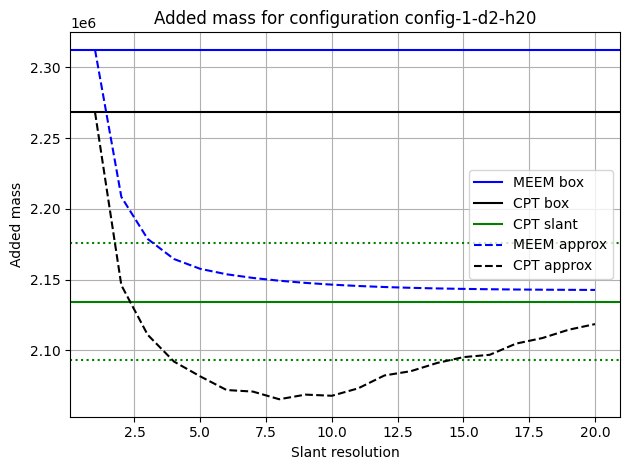

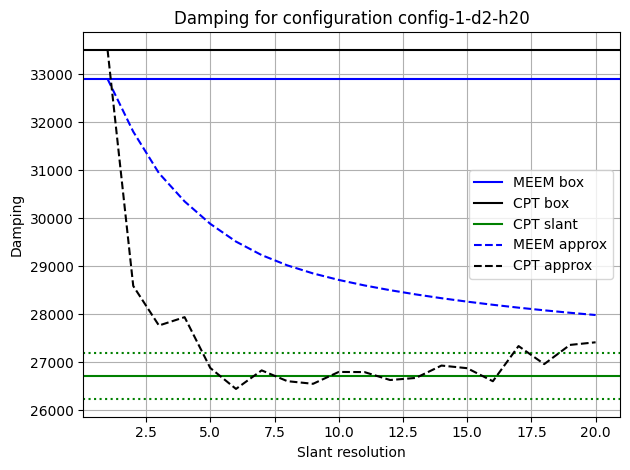

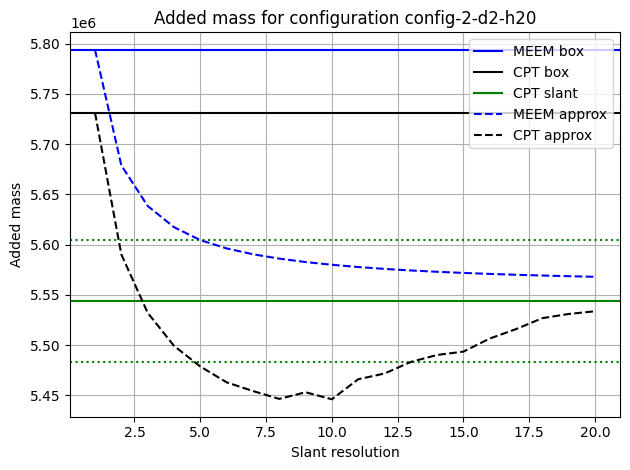

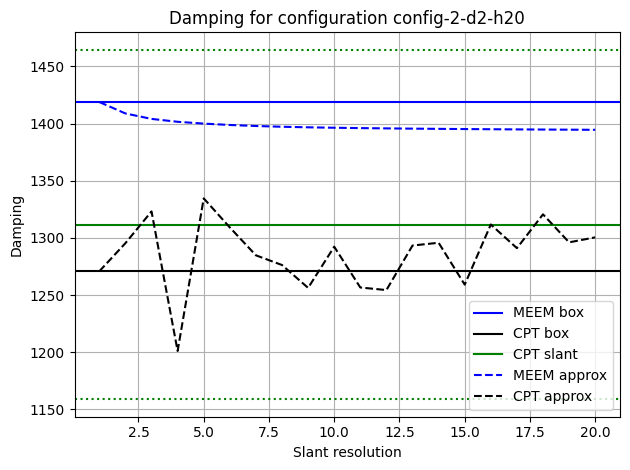

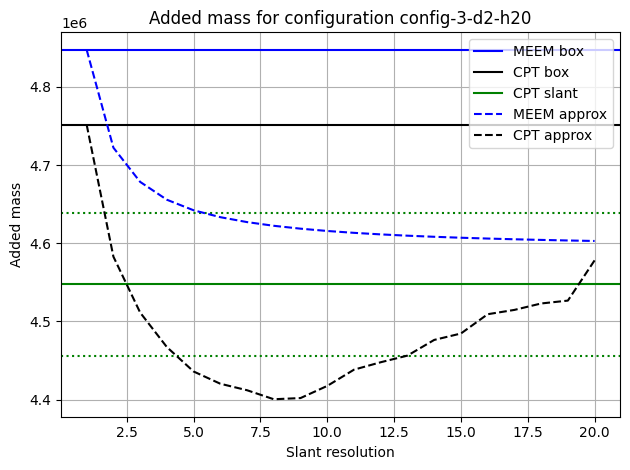

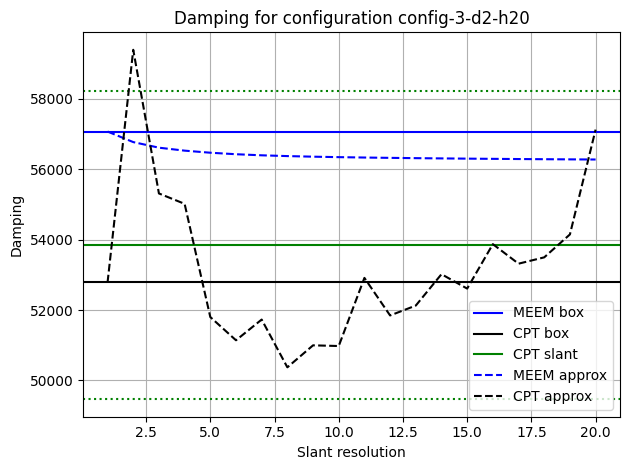

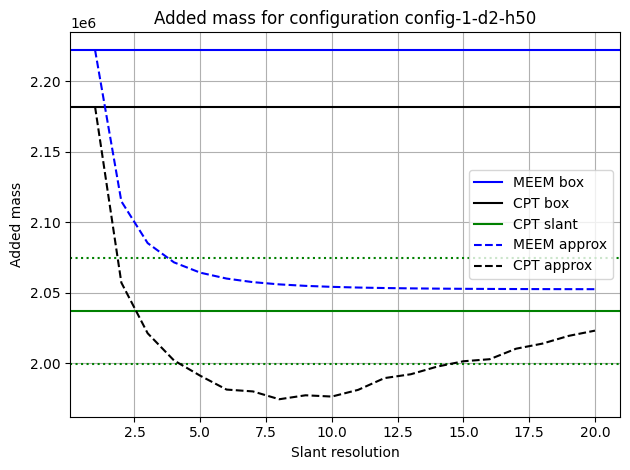

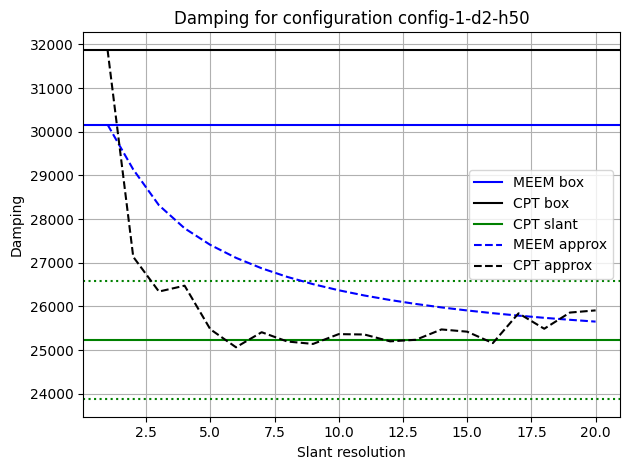

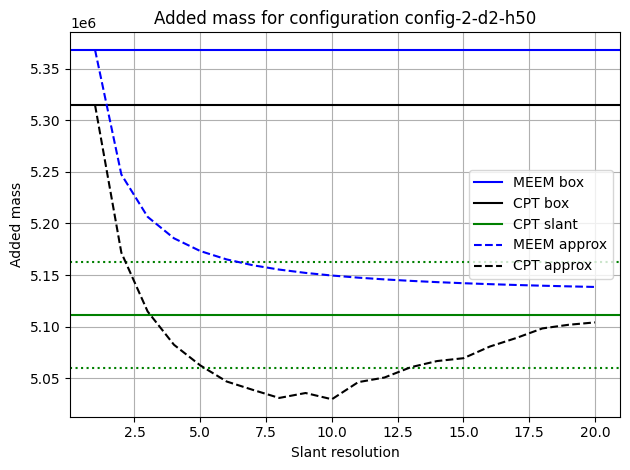

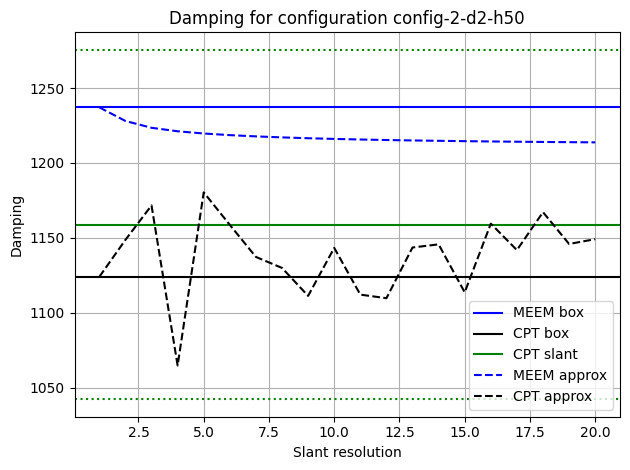

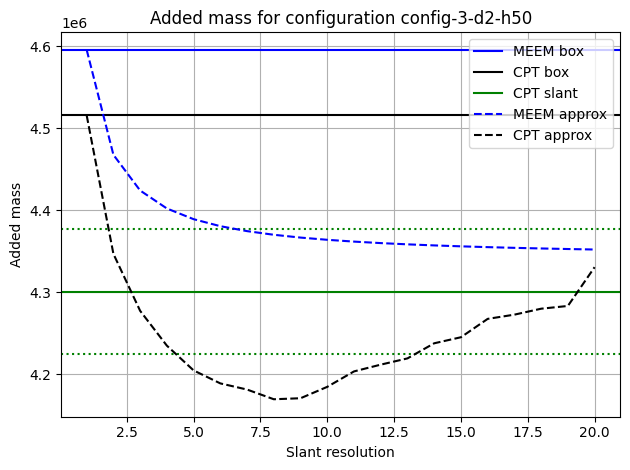

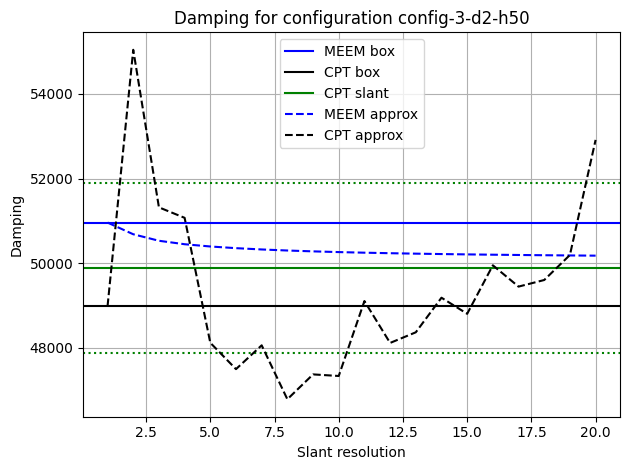

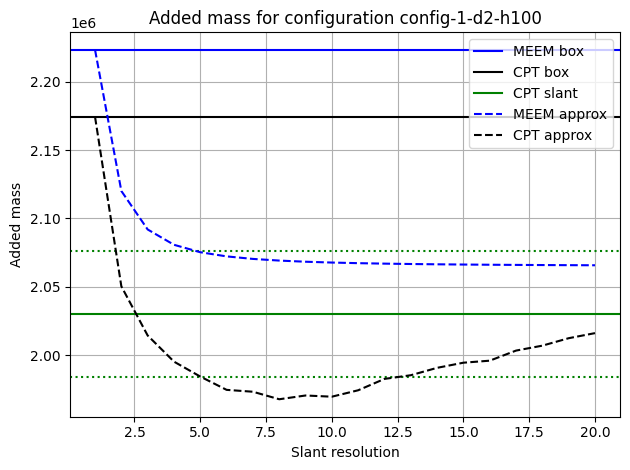

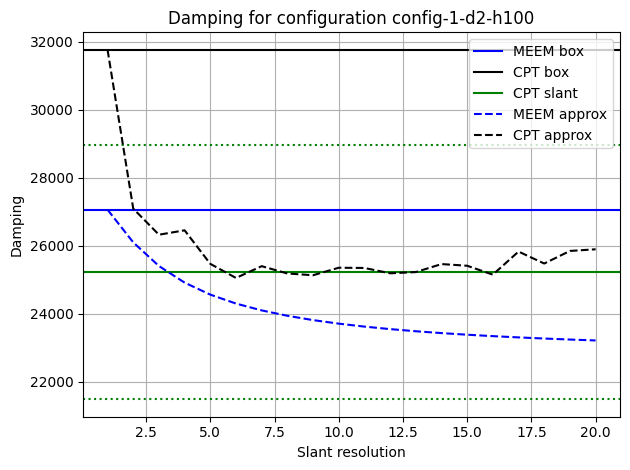

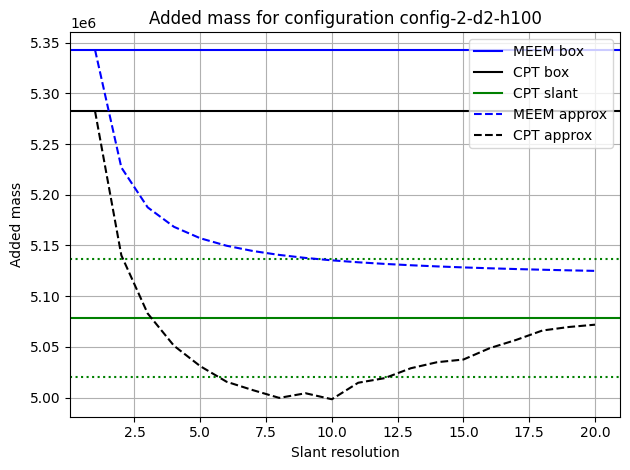

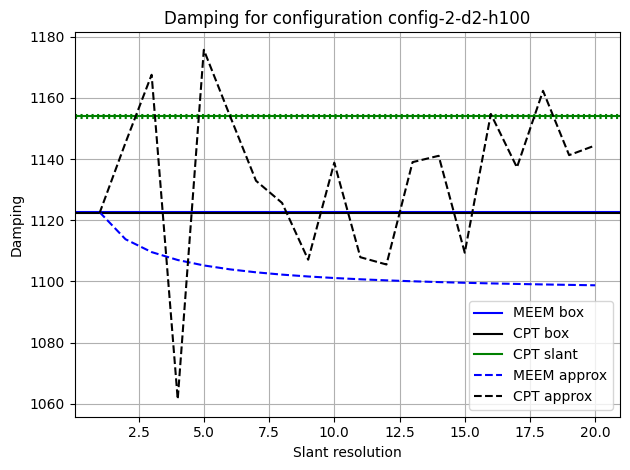

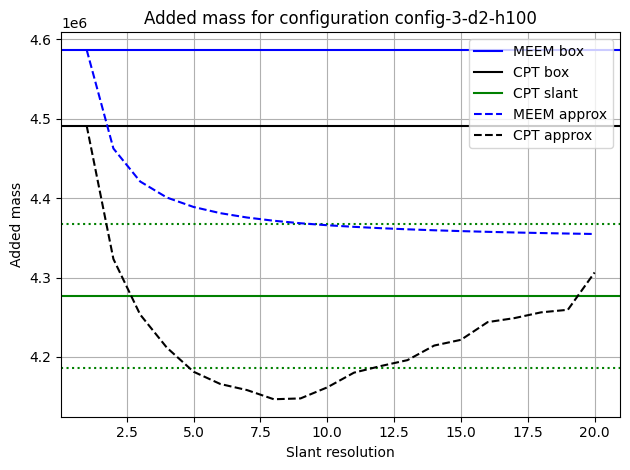

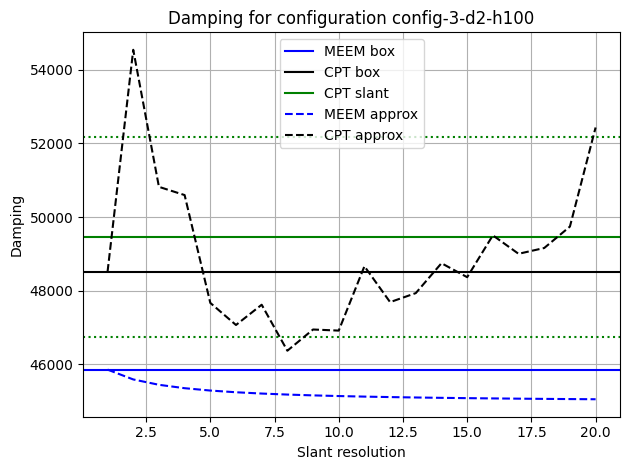

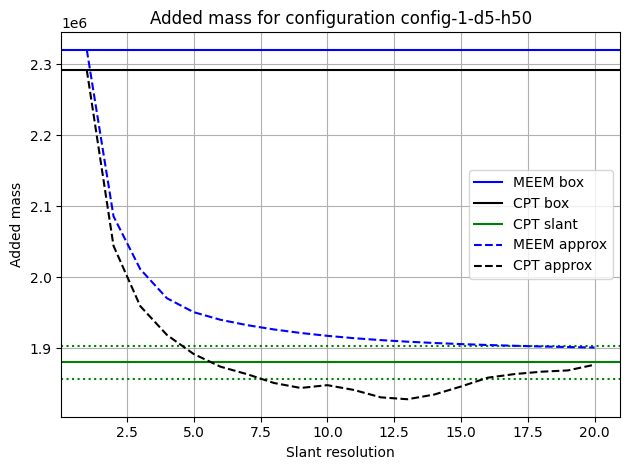

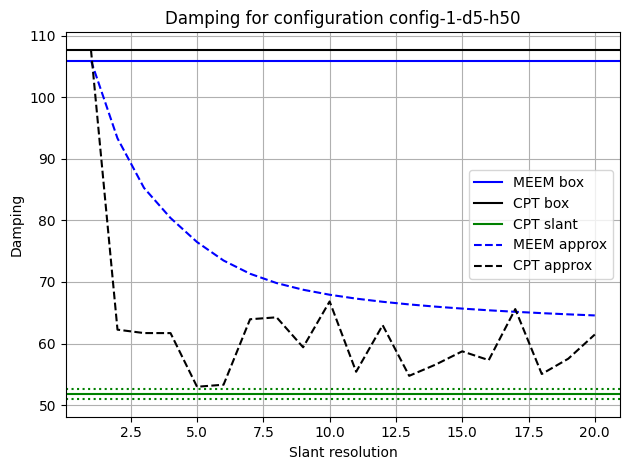

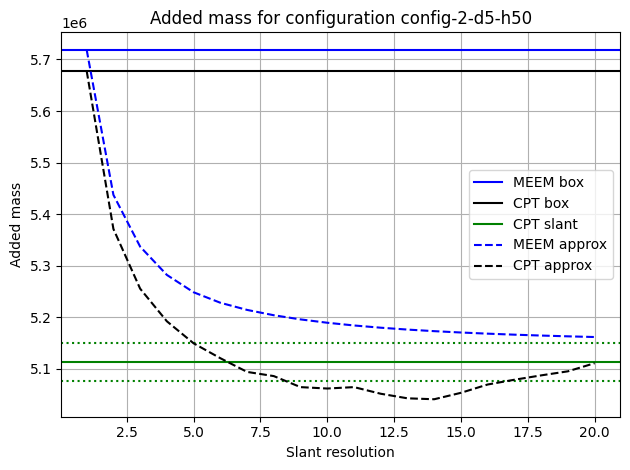

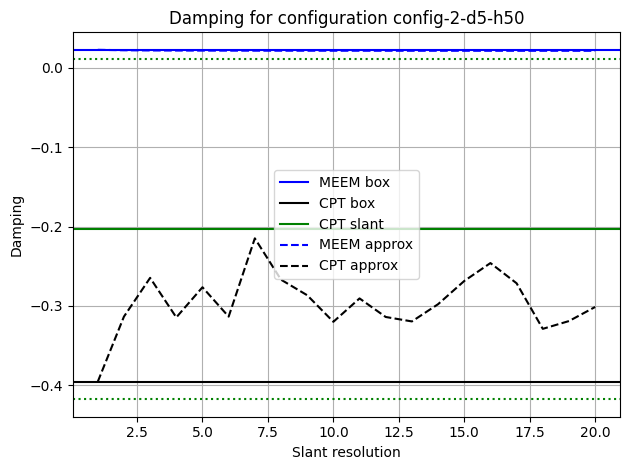

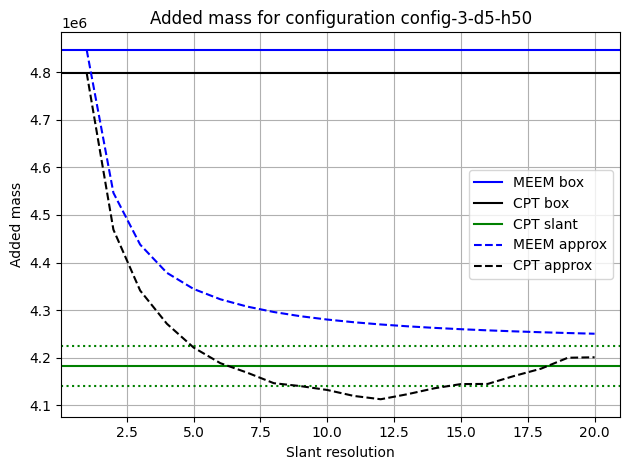

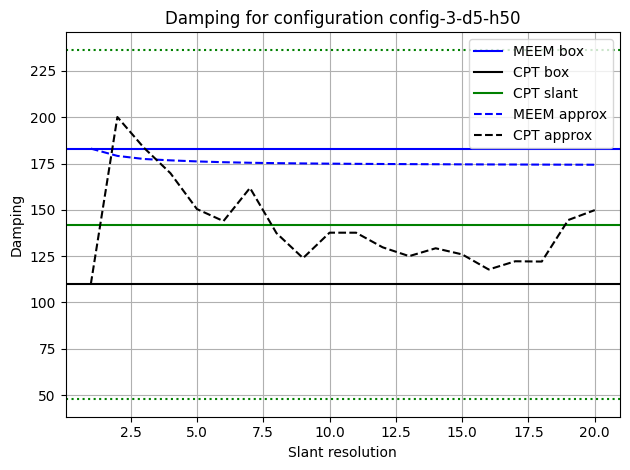

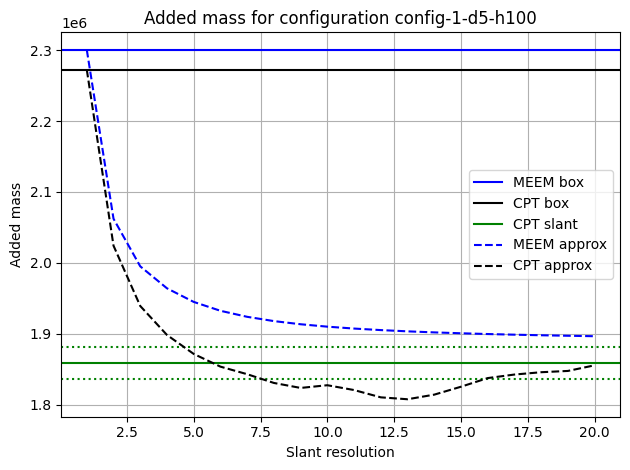

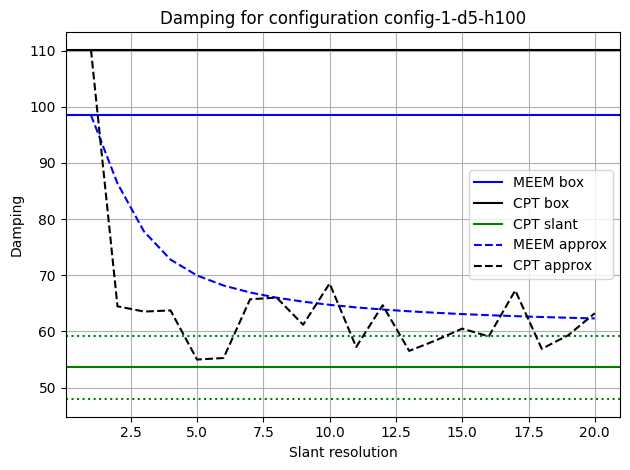

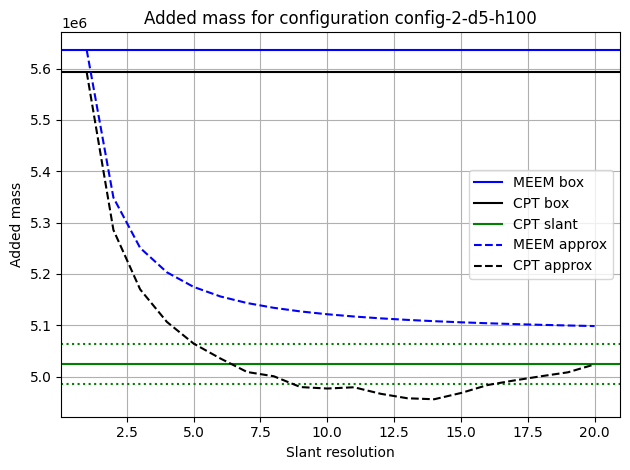

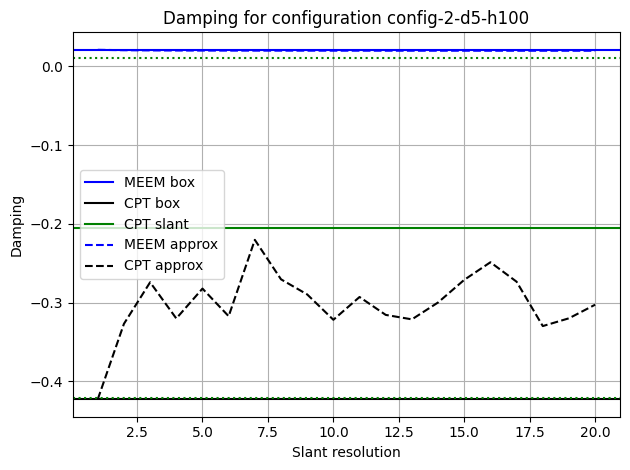

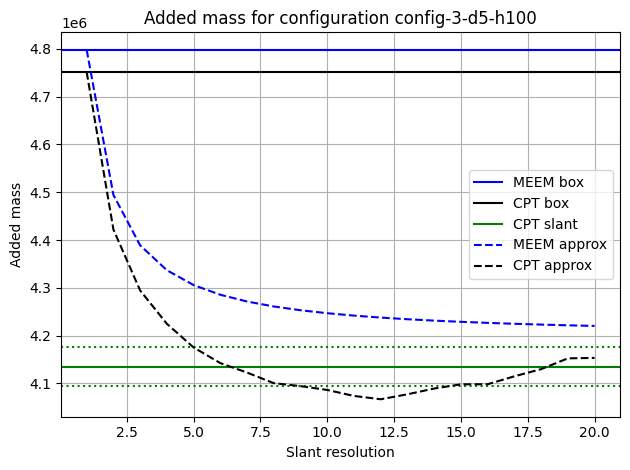

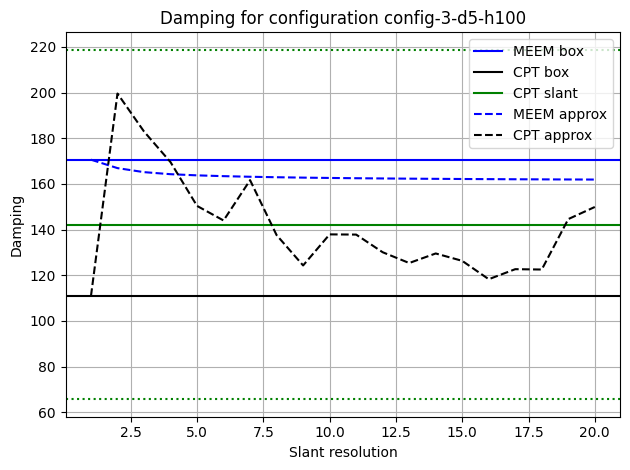

In [33]:
def plot_comparison(meem_box, cpt_box, cpt_slant, meem_approx, cpt_approx, coeff_name, config_name):
  x = list(range(1, 21))

  margin = abs(cpt_box - meem_box)/cpt_box

  plt.axhline(y = meem_box, color='blue', linestyle='-', label = "MEEM box")
  plt.axhline(y = cpt_box, color='black', linestyle='-', label = "CPT box")
  plt.axhline(y = cpt_slant, color='green', linestyle='-', label = "CPT slant")
  plt.axhline(y = cpt_slant * (1 + margin), color='green', linestyle=':')
  plt.axhline(y = cpt_slant * (1 - margin), color='green', linestyle=':')

  plt.plot(x, meem_approx, label='MEEM approx', color = "blue", linestyle = "--")
  plt.plot(x, cpt_approx, label='CPT approx', color = "black", linestyle = "--")

  # Labels and title
  plt.xlabel('Slant resolution')
  plt.ylabel(coeff_name)
  plt.title(coeff_name + " for configuration " + config_name)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  # Show the plot
  plt.show()


def plot_slant_convergences(config, data_dict):
  name = config["name"]
  plot_comparison(data_dict["MEEM box AM"], data_dict["CPT box AM"], data_dict["CPT slant AM"],
                  data_dict["MEEM approx AMs"], data_dict["CPT approx AMs"], "Added mass", name)
  plot_comparison(data_dict["MEEM box DP"], data_dict["CPT box DP"], data_dict["CPT slant DP"],
                  data_dict["MEEM approx DPs"], data_dict["CPT approx DPs"], "Damping", name)
  
for config in configurations:
  with open("data/" + config["name"] + ".pkl", "rb") as f:
    data_dict = pickle.load(f)
  plot_slant_convergences(config, data_dict)

Compute the time cost of various parts of the process, to get a sense of how inefficient slant approximating is.

In [25]:
# Three major time components:
# (1) m_k calculations.
# (2) A-matrix computation.
# (3) Matrix solving.

h = 50
a = [6, 12, 15]
din = [6, 6, 4]
dout = [6, 4, 4]
heaving = [0, 1, 1]
m0 = 0.9
rho = 1023


def solve_MEEM_with_times(h, d, a, heaving, NMK, m0, rho):
  start = time.perf_counter()
  prob = Problem(h, d, a, heaving, NMK, m0, rho)
  end = time.perf_counter()
  t_m_k = end - start # technically not, but driven by m_k solving

  start = time.perf_counter()
  a_matrix = prob.a_matrix()
  end = time.perf_counter()
  t_a = end - start

  b_vector = prob.b_vector()

  start = time.perf_counter()
  x = prob.get_unknown_coeffs(a_matrix, b_vector)
  end = time.perf_counter()
  t_x = end - start

  return t_m_k, t_a, t_x

def average_three_outputs(func, *args, **kwargs):
    outputs = [[], [], []]

    for _ in range(5):
        out1, out2, out3 = func(*args, **kwargs)
        outputs[0].append(out1)
        outputs[1].append(out2)
        outputs[2].append(out3)

    avg1 = np.mean(outputs[0], axis=0)
    avg2 = np.mean(outputs[1], axis=0)
    avg3 = np.mean(outputs[2], axis=0)

    return avg1, avg2, avg3

def vary_NMK(h, a, d_in, d_out, heaving, res, m0, rho):
  m_k_times = []
  a_times = []
  x_times = []
  for i in range(10, 50):
    NMK = [i] * len(a)
    newvars = slant_approx_vars(a, d_in, d_out, heaving, NMK, res)
    times = average_three_outputs(solve_MEEM_with_times, h, newvars[0], newvars[1], newvars[4], newvars[5], m0, rho)
    m_k_times.append(times[0])
    a_times.append(times[1])
    x_times.append(times[2])
  return m_k_times, a_times, x_times

def vary_res(h, a, d_in, d_out, heaving, NMK, m0, rho):
  m_k_times = []
  a_times = []
  x_times = []
  for res in range(1, 31):
    newvars = slant_approx_vars(a, d_in, d_out, heaving, NMK, res)
    times = solve_MEEM_with_times(h, newvars[0], newvars[1], newvars[4], newvars[5], m0, rho)
    m_k_times.append(times[0])
    a_times.append(times[1])
    x_times.append(times[2])
  return m_k_times, a_times, x_times

def plot_times(x, y1, y2, y3, xlabel, labels, title='Computation Times'):
    plt.plot(x, y1, label=labels[0], marker='o')
    plt.plot(x, y2, label=labels[1], marker='s')
    plt.plot(x, y3, label=labels[2], marker='^')

    plt.xlabel(xlabel)
    plt.ylabel('time')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
vNMK_times = vary_NMK(h, a, din, dout, heaving, 15, m0, rho)
vres_times = vary_res(h, a, din, dout, heaving, [30] * 4, m0, rho)

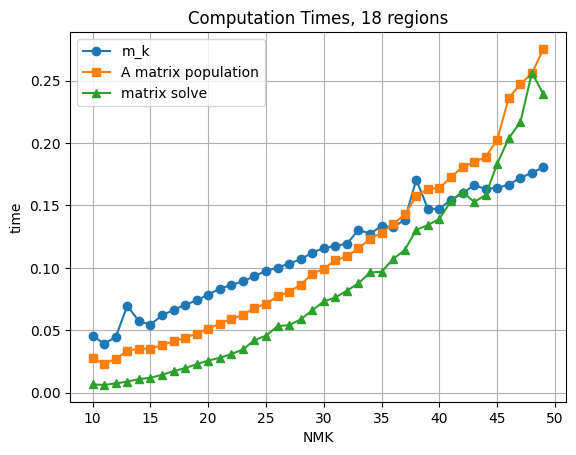

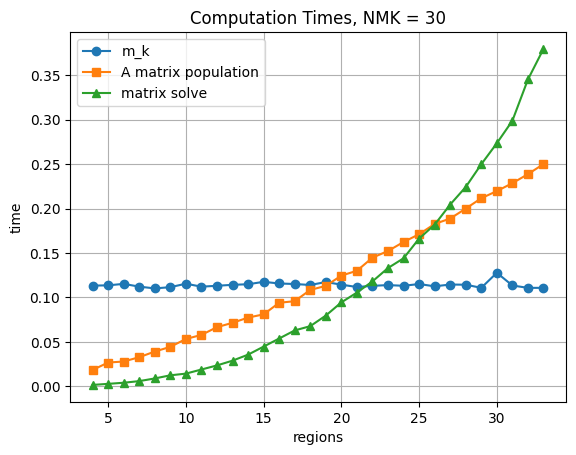

In [28]:
labels = ["m_k", "A matrix population", "matrix solve"]
plot_times(range(10, 50), vNMK_times[0], vNMK_times[1], vNMK_times[2], "NMK", labels, title='Computation Times, 18 regions')
plot_times(range(4, 34), vres_times[0], vres_times[1], vres_times[2], "regions", labels, title='Computation Times, NMK = 30')